## Import packages and export necessary dynamo functions
1. Import dynamo and other analysis or visualization tools
2. export vector field analysis or simulation benchmark related functions from dynamo  

In [1]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn
import numpy as np
import pandas as pd 
import seaborn as sns

import matplotlib.pyplot as plt 
import matplotlib
from dynamo.vectorfield.utils import vector_field_function, compute_acceleration, compute_curvature, compute_curl, compute_divergence
from dynamo.simulation.ODE import two_genes_motif, two_genes_motif_jacobian

%matplotlib inline

## Setup adata: 
1. generate RNA velocity dataset for a two-gene network motif system
2. set up the adata for downstream vector field and differential geometry analysis. 

In [2]:
adata = dyn.sim.Simulator(motif="twogenes")
adata.obsm['X_umap'], adata.obsm['velocity_umap'] = adata.X, adata.layers['velocity']
dyn.tl.neighbors(adata, basis='umap')

adata.obs['ntr'] = 0

adata.obsm["X_pca"] = adata.obsm["X_umap"]
adata.obsm['velocity_pca'] = adata.obsm['velocity_umap'].copy()

adata.var['use_for_pca'] = True
adata.var['use_for_dynamics'] = True
adata.var['use_for_transition'] = True
adata.var['gamma'] = 1
adata.var["use_for_transition"] = True

adata.layers['velocity_S'] = adata.layers['velocity'].copy()

a = np.zeros((2, 2), int)
np.fill_diagonal(a, 1)

adata.uns['PCs'] = a

adata.uns['dynamics'] = {}
adata.uns['dynamics']["use_smoothed"] = True
adata.uns['dynamics']["has_splicing"] = True
adata.uns['dynamics']["has_labeling"] = False
adata.uns['dynamics']["NTR_vel"] = False
adata.uns['dynamics']["est_method"] = 'ols'
adata.uns['dynamics']['experiment_type'] = None

In [3]:
adata

AnnData object with n_obs × n_vars = 5000 × 2
    obs: 'ntr'
    var: 'use_for_pca', 'use_for_dynamics', 'use_for_transition', 'gamma'
    uns: 'neighbors', 'PCs', 'dynamics'
    obsm: 'X_umap', 'velocity_umap', 'X_pca', 'velocity_pca'
    layers: 'velocity', 'velocity_S'
    obsp: 'connectivities', 'distances'

## Calculate vector-field based pseudotime and identify fixed points
1. Calculate vector-field based pseudotime via ddhoge by taking advantabe of hodge decomposition on a simplical graph. 
2. Identify stable fixed point (attractor, full-cycle) or unstable fixed point (saddle point, half-cycle)
3. save the topograph plot 

There are quiet a few parameters for the vector field reconstruction. You can check the documentation to understand the meaning of each of them

`?dyn.vf.SparseVFC`. 

In addition, you may also refer to the table 1 in our supplementary method in our dynamo preprint: https://www.biorxiv.org/content/10.1101/696724v2.full. 

Constructing diffusion graph from reconstructed vector field: 5000it [02:03, 40.38it/s]
Calculating divergence: 100%|██████████| 5000/5000 [00:00<00:00, 10900.05it/s]


<Figure size 600x400 with 0 Axes>

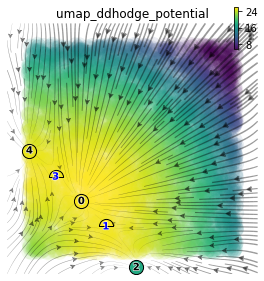

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/topography_dyn_savefig.png...
Done


<Figure size 400x300 with 0 Axes>

In [4]:
# , a = 5, beta = 0.1, ecr = 1e-5, gamma = 0.9, lambda_ = 3, minP = 1e-5, theta = 0.75

dyn.vf.VectorField(adata, basis='umap', pot_curl_div=True, M = 250, MaxIter = 100)
dyn.pl.topography(adata, color='umap_ddhodge_potential')

dyn.pl.topography(adata, basis='umap', color='umap_ddhodge_potential', save_show_or_return='save',
                        streamline_kwargs = {
                             "linewidth": None,
                             "cmap": None,
                             "norm": None,
                             "arrowsize": 1,
                             "arrowstyle": "fancy",
                             "minlength": 0.1,
                             "transform": None,
                             "start_points": None,
                             "maxlength": 4.0,
                             "integration_direction": "both",
                             "zorder": 3,
                         },
                        save_kwargs={'prefix': './figures/topography', 'ext': 'png',
                                     "bbox_inches": None},
                        figsize=(4, 3))

### if you want to save the adata, you may use the following code: 
dyn.cleanup(adata)

adata.write_h5ad('./vector_calculus_adata.h5ad')

## Learn vector field function and calculate Jacobian, curl and divergence on the simulated dataset
1. We first learn the continous, differentiable vector field function with the simulated dataset
2. Then the continous vector field function can be used to calculate Jacobian, curl and divergence for any cell state. 
3. Lastly, we can plot and save the curl and divergence landscape plots for the simulated dataset. 

In [5]:
dyn.vf.VectorField(adata, basis='pca', M = 250, MaxIter = 100)

AnnData object with n_obs × n_vars = 5000 × 2
    obs: 'ntr', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca'
    var: 'use_for_pca', 'use_for_dynamics', 'use_for_transition', 'gamma'
    uns: 'neighbors', 'PCs', 'dynamics', 'VecFld_umap', 'VecFld', 'VecFld_pca'
    obsm: 'X_umap', 'velocity_umap', 'X_pca', 'velocity_pca', 'velocity_umap_SparseVFC', 'X_umap_SparseVFC', 'velocity_pca_SparseVFC', 'X_pca_SparseVFC'
    layers: 'velocity', 'velocity_S'
    obsp: 'connectivities', 'distances', 'umap_ddhodge'

In [6]:
dyn.vf.jacobian(adata, basis='umap', regulators=['Pu.1', 'Gata.1'],
                effectors=['Pu.1', 'Gata.1'], store_in_adata=True)

dyn.vf.curl(adata, basis='pca')
dyn.vf.divergence(adata, basis='pca')

Calculating divergence: 100%|██████████| 5000/5000 [00:00<00:00, 8819.39it/s]


<Figure size 600x400 with 0 Axes>

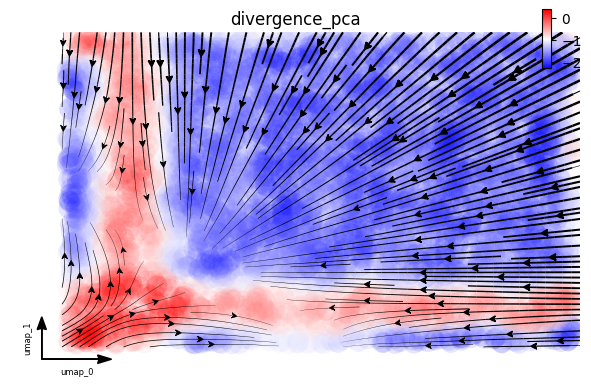

<Figure size 600x400 with 0 Axes>

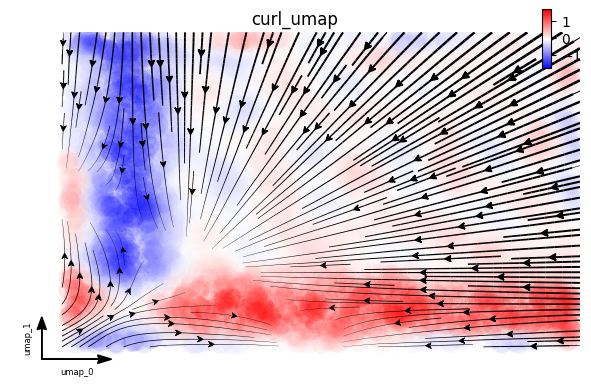

In [8]:
dyn.pl.streamline_plot(adata, color='divergence_pca', cmap='bwr')
dyn.pl.streamline_plot(adata, color='curl_umap', cmap='bwr')

In [9]:

# plot divergence
dyn.pl.divergence(adata, basis='pca', save_show_or_return='save', show_arrowed_spines=False,
                  pointsize=0.05,
                  save_kwargs={'prefix': './figures/Fig4_divergence', 'ext': 'pdf',
                                     "bbox_inches": None},
                        figsize=(2, 2))
# estimated ones:

# plot curl
dyn.pl.curl(adata, basis='pca', save_show_or_return='save', show_arrowed_spines=False,
                  pointsize=0.05,
                  save_kwargs={'prefix': './figures/Fig4_curl', 'ext': 'pdf',
                                     "bbox_inches": None},
                        figsize=(2, 2))



Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_divergence_dyn_savefig.pdf...
Done
Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_curl_dyn_savefig.pdf...
Done


<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

## Compute acceleration, curvature with the vector field function learned from the simulated dataset
1. Set up a vector field class with the learned vector field function 
2. Use the continous vector field function to calculate acceleration and curvature vectors for all simulated cell state in pca space. 
3. Project the acceleration, curvature vectors to umap space. 
4. Lastly, visualize the acceleration, curvature vector field, color cell by the accleration / curvature vector magnitude. This can be compared with the velocity vector field. 

Note that in our simulation, pca and umap space are in fact the same but for real datasets, you can project the acceleration, curvature vectors to umap space, just like the velocity vectors on pca space. 


In [10]:
from dynamo.vectorfield.scVectorField import svc_vectorfield
vector_field_class = svc_vectorfield()
vector_field_class.from_adata(adata, basis='pca')

adata.obs['acceleration_pca'], adata.obsm['acceleration_pca'] = vector_field_class.compute_acceleration()
adata.obs['curvature_pca'], adata.obsm['curvature_pca'] = vector_field_class.compute_curvature()
adata.obsm['X_curvature_pca'] = adata.obsm['X_pca'].copy()
adata.obsm['X_acceleration_pca'] = adata.obsm['X_pca'].copy()

Calculating curvature: 100%|██████████| 5000/5000 [00:00<00:00, 59973.98it/s]


In [11]:
adata.uns['jacobian_umap']['jacobian'][1].shape

(2, 5000)

In [12]:
adata.layers['M_s'], adata.layers['M_u'] = adata.X.copy(), adata.X.copy()

dyn.vf.cell_accelerations(adata, basis='umap', regulators=['Pu.1', 'Gata.1'],
                effectors=['Pu.1', 'Gata.1'], store_in_adata=True)
dyn.vf.cell_curvatures(adata, basis='umap', regulators=['Pu.1', 'Gata.1'],
                effectors=['Pu.1', 'Gata.1'], store_in_adata=True)


calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 5000/5000 [00:01<00:00, 3370.83it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 5000/5000 [00:01<00:00, 3424.01it/s]
rescaling velocity norm...: 100%|██████████| 5000/5000 [00:01<00:00, 4686.33it/s]
calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 5000/5000 [00:01<00:00, 3539.81it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 5000/5000 [00:01<00:00, 3673.48it/s]
rescaling velocity norm...: 100%|██████████| 5000/5000 [00:01<00:00, 4660.73it/s]


<Figure size 600x400 with 0 Axes>

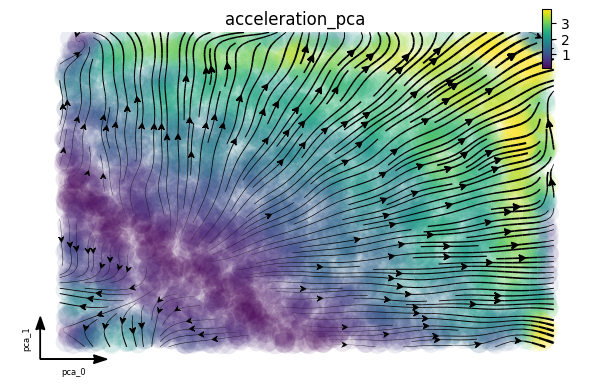

<Figure size 600x400 with 0 Axes>

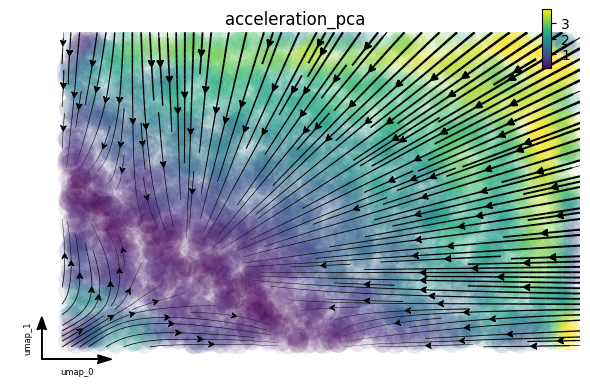

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/acceleration_pca_field_dyn_savefig.png...
Done
Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/acceleration_pca_dyn_savefig.png...
Done


<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [13]:
# plot acceleration
dyn.pl.streamline_plot(adata, vector='acceleration', color='acceleration_pca', basis='pca')
dyn.pl.streamline_plot(adata, color='acceleration_pca')

dyn.pl.streamline_plot(adata, vector='acceleration', color='acceleration_pca', basis='pca', save_show_or_return='save',
                        pointsize=0.4, show_arrowed_spines=False,
                       streamline_kwargs = {
                             "linewidth": None,
                             "cmap": None,
                             "norm": None,
                             "arrowsize": 1,
                             "arrowstyle": "fancy",
                             "minlength": 0.1,
                             "transform": None,
                             "start_points": None,
                             "maxlength": 4.0,
                             "integration_direction": "both",
                             "zorder": 3,
                         },
                       save_kwargs={'prefix': './figures/acceleration_pca_field', 'ext': 'png',
                                     "bbox_inches": None},
                        figsize=(4, 3))
dyn.pl.streamline_plot(adata, color='acceleration_pca', save_show_or_return='save',
                        pointsize=0.4, show_arrowed_spines=False,
                       streamline_kwargs = {
                             "linewidth": None,
                             "cmap": None,
                             "norm": None,
                             "arrowsize": 1,
                             "arrowstyle": "fancy",
                             "minlength": 0.1,
                             "transform": None,
                             "start_points": None,
                             "maxlength": 4.0,
                             "integration_direction": "both",
                             "zorder": 3,
                         },
                       save_kwargs={'prefix': './figures/acceleration_pca', 'ext': 'png',
                                     "bbox_inches": None},
                        figsize=(4, 3))


<Figure size 600x400 with 0 Axes>

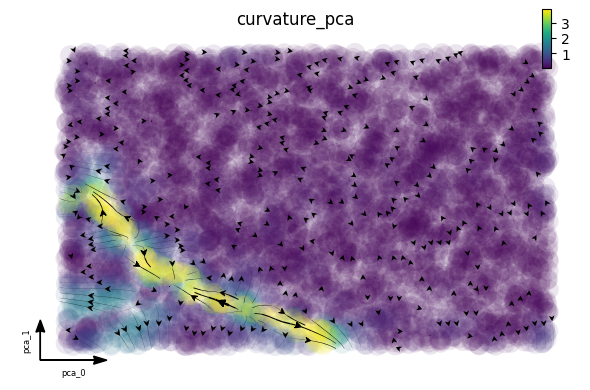

<Figure size 600x400 with 0 Axes>

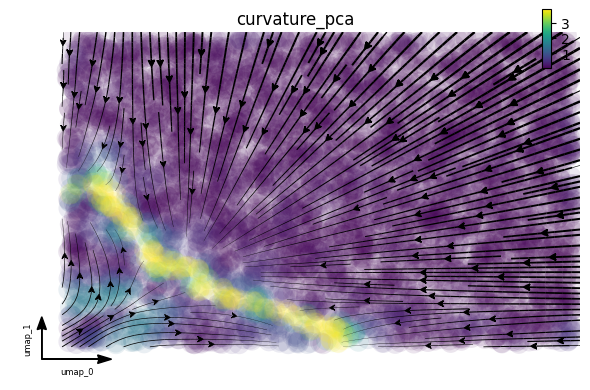

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/curvature_pca_field_dyn_savefig.png...
Done
Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/curvature_pca_dyn_savefig.png...
Done


<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [14]:
# plot curvature
dyn.pl.streamline_plot(adata, vector='curvature', color='curvature_pca', basis='pca')
dyn.pl.streamline_plot(adata, color='curvature_pca')

dyn.pl.streamline_plot(adata, vector='curvature', color='curvature_pca', basis='pca', save_show_or_return='save',
                        pointsize=0.4, show_arrowed_spines=False,
                       streamline_kwargs = {
                             "linewidth": None,
                             "cmap": None,
                             "norm": None,
                             "arrowsize": 1,
                             "arrowstyle": "fancy",
                             "minlength": 0.1,
                             "transform": None,
                             "start_points": None,
                             "maxlength": 4.0,
                             "integration_direction": "both",
                             "zorder": 3,
                         },
                       save_kwargs={'prefix': './figures/curvature_pca_field', 'ext': 'png',
                                     "bbox_inches": None},
                        figsize=(4, 3))
dyn.pl.streamline_plot(adata, color='curvature_pca', save_show_or_return='save',
                        pointsize=0.4,show_arrowed_spines=False,
                       streamline_kwargs = {
                             "linewidth": None,
                             "cmap": None,
                             "norm": None,
                             "arrowsize": 1,
                             "arrowstyle": "fancy",
                             "minlength": 0.1,
                             "transform": None,
                             "start_points": None,
                             "maxlength": 4.0,
                             "integration_direction": "both",
                             "zorder": 3,
                         },
                       save_kwargs={'prefix': './figures/curvature_pca', 'ext': 'png',
                                     "bbox_inches": None},
                        figsize=(4, 3))


## Visualize the vector field produced by each basis function and identify the contribution from each control point 
1. Visualze the streamline plot of the vector field produced by each basis function;
2. Sort the contribution of each control by calculating the norm of each row from the weight matrix C; 
3. Create quiver plots of the control points and the corresponding weight vectors; 
4. Create quiver plots of the vector fields produced from the basis function corresponding to the control points with the smallest weight; 
4. Lastly, save the streamline/quiver plots generated with vector field basis function corresponding to a few control points. 

Note that in our vector field learning algorithm implementation, the 'X_ctrl' key in the VecFld dictionary corresponds to the coordinates of control points, while the 'C' key the weight vector for each control point to each vector field dimension.  

<Figure size 600x400 with 0 Axes>

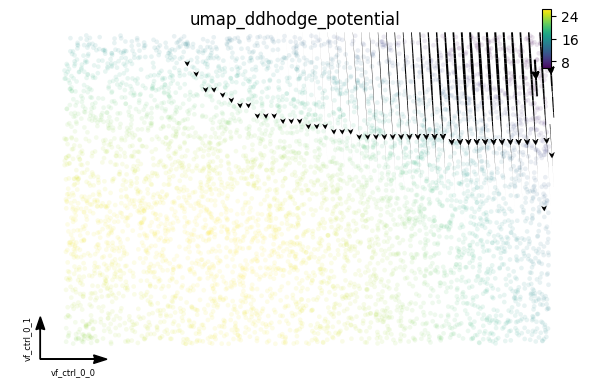

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/velocity_vf_ctrl_0_dyn_savefig.png...
Done


<Figure size 400x300 with 0 Axes>

<Figure size 600x400 with 0 Axes>

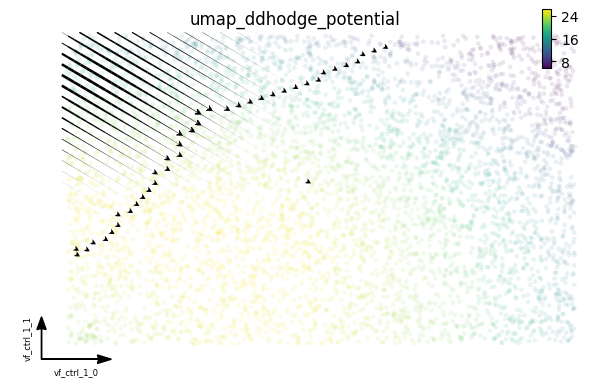

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/velocity_vf_ctrl_1_dyn_savefig.png...
Done


<Figure size 400x300 with 0 Axes>

<Figure size 600x400 with 0 Axes>

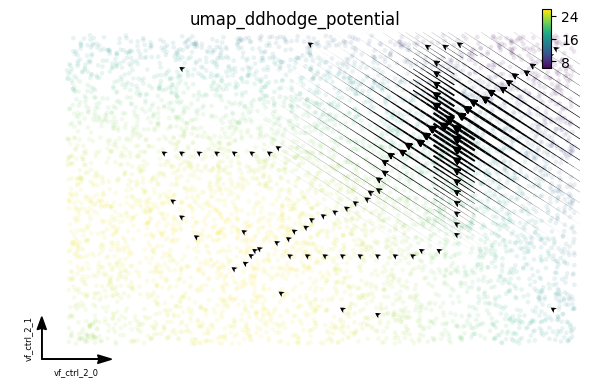

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/velocity_vf_ctrl_2_dyn_savefig.png...
Done


<Figure size 400x300 with 0 Axes>

In [15]:
X = adata.X

vf_ctrl_0 = vector_field_function(X, adata.uns['VecFld_umap'], X_ctrl_ind=0)
adata.obsm['velocity_vf_ctrl_0'] = vf_ctrl_0
adata.obsm['X_vf_ctrl_0'] = adata.obsm['X_pca']
dyn.pl.streamline_plot(adata, basis='vf_ctrl_0', pointsize=0.05, color='umap_ddhodge_potential')
dyn.pl.streamline_plot(adata, basis='vf_ctrl_0', pointsize=0.05, color='umap_ddhodge_potential',alpha=1,
                       show_arrowed_spines=False,
                       save_show_or_return='save',
                       streamline_kwargs = {
                             "linewidth": None,
                             "cmap": None,
                             "norm": None,
                             "arrowsize": 1,
                             "arrowstyle": "fancy",
                             "minlength": 0.1,
                             "transform": None,
                             "start_points": None,
                             "maxlength": 4.0,
                             "integration_direction": "both",
                             "zorder": 3,
                         },
                       save_kwargs={'prefix': './figures/velocity_vf_ctrl_0', 'ext': 'png',
                                     "bbox_inches": None},
                        figsize=(4, 3))

vf_ctrl_1 = vector_field_function(X, adata.uns['VecFld_umap'], X_ctrl_ind=1)
adata.obsm['velocity_vf_ctrl_1'] = vf_ctrl_1
adata.obsm['X_vf_ctrl_1'] = adata.obsm['X_pca']
dyn.pl.streamline_plot(adata, basis='vf_ctrl_1', pointsize=0.05, color='umap_ddhodge_potential')
dyn.pl.streamline_plot(adata, basis='vf_ctrl_1', pointsize=0.05, color='umap_ddhodge_potential',alpha=1,
                       show_arrowed_spines=False,
                       save_show_or_return='save',
                       streamline_kwargs={
                           "linewidth": None,
                           "cmap": None,
                           "norm": None,
                           "arrowsize": 1,
                           "arrowstyle": "fancy",
                           "minlength": 0.1,
                           "transform": None,
                           "start_points": None,
                           "maxlength": 4.0,
                           "integration_direction": "both",
                           "zorder": 3,
                       },
                       save_kwargs={'prefix': './figures/velocity_vf_ctrl_1', 'ext': 'png',
                                    "bbox_inches": None},
                       figsize=(4, 3)
                       )

vf_ctrl_2 = vector_field_function(X, adata.uns['VecFld_umap'], X_ctrl_ind=2)
adata.obsm['velocity_vf_ctrl_2'] = vf_ctrl_2
adata.obsm['X_vf_ctrl_2'] = adata.obsm['X_pca']
dyn.pl.streamline_plot(adata, basis='vf_ctrl_2', pointsize=0.05, color='umap_ddhodge_potential')
dyn.pl.streamline_plot(adata, basis='vf_ctrl_2', pointsize=0.05, color='umap_ddhodge_potential', alpha=1,
                       show_arrowed_spines=False,
                       save_show_or_return='save',
                       streamline_kwargs={
                           "linewidth": None,
                           "cmap": None,
                           "norm": None,
                           "arrowsize": 1,
                           "arrowstyle": "fancy",
                           "minlength": 0.1,
                           "transform": None,
                           "start_points": None,
                           "maxlength": 4.0,
                           "integration_direction": "both",
                           "zorder": 3,
                       },
                       save_kwargs={'prefix': './figures/velocity_vf_ctrl_2', 'ext': 'png',
                                    "bbox_inches": None},
                       figsize=(4, 3)
                       )

In [16]:
adata.uns['VecFld_umap'].keys()

dict_keys(['X', 'valid_ind', 'X_ctrl', 'ctrl_idx', 'Y', 'beta', 'V', 'C', 'P', 'VFCIndex', 'sigma2', 'grid', 'grid_V', 'iteration', 'tecr_traj', 'E_traj', 'method', 'dims', 'VecFld', 'VecFld2D', 'xlim', 'ylim'])

In [17]:
adata.uns['VecFld_umap']['C'].shape

(250, 2)

### calculate the contribution for each control point 

In [18]:
np.argsort(np.linalg.norm(adata.uns['VecFld_umap']['C'], axis=1))

array([ 98,  48, 144, 102,  43, 148, 156, 122, 136,  62,  91, 150,  26,
       207, 135,  27, 196, 111, 143,  31,  52,  92, 166,  69, 171, 145,
        60, 219, 126, 153,  32, 182, 162, 141, 249, 232, 242, 236, 180,
        21, 190,  53, 132,  73,  35,   1, 233,  30, 217, 221,   3,   6,
        83, 117,  19, 185, 247, 237, 138,  94,  70,   5, 220,  64,  28,
         0,  58,  13, 159, 211,  85,  22, 194,  20,  57, 226,  29,  86,
       231,  25, 228, 120,  47, 125, 160, 178,  40, 165, 208,  16,  67,
        79, 100, 168, 154, 216,  51,  77, 118,  72, 173, 116, 123, 225,
        49, 184, 227,  44, 199, 129, 158,  34, 103, 189, 239, 174, 121,
       245, 146,  56, 191, 229, 215, 235, 241,  36, 238, 163, 149, 203,
       212,  97, 164,  18,   9,  10, 175,  54,  75, 206, 151, 172, 205,
        66, 195,  24, 179,  68, 181, 152,  11,  39, 109, 183,  59,  89,
       230, 193, 213,   8,  71,  93, 204, 147, 157, 124,  99,   2,  96,
       107,  42,  80, 119, 223, 104,  84, 176,  90, 243, 188,  8

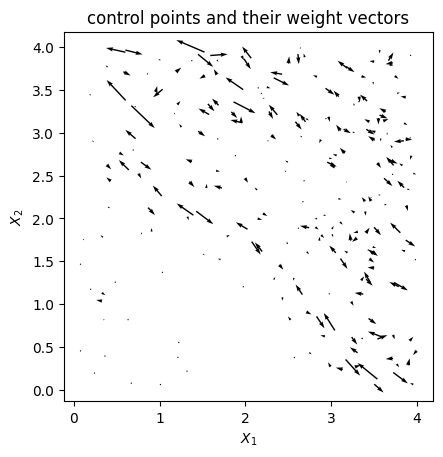

In [19]:
X_ctrl = adata.uns['VecFld_umap']['X_ctrl'] # vector_field_function(analytical_X, adata.uns['VecFld']['VecFld'], X_ctrl_ind=i)
C = adata.uns['VecFld_umap']['C'] 

import matplotlib.pyplot as plt 
plt.quiver(X_ctrl[:, 0], X_ctrl[:, 1], C[:, 0], C[:, 1], units='xy', 
           scale=500) # , color = norm, 
plt.gca().set_aspect('equal') #, adjustable='box'
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.title('control points and their weight vectors')
plt.show()

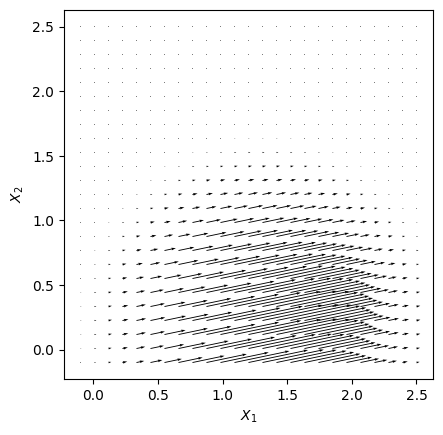

In [20]:
npts = 25
xmin, xmax = -0.1, 2.5
x1 = np.linspace(xmin, xmax, npts)
x2 = np.linspace(xmin, xmax, npts)

X1_25, X2_25 = np.meshgrid(x1, x2)

analytical_X = np.vstack([X1_25.flatten(), X2_25.flatten()]).T
vf_ctrl_0 = vector_field_function(analytical_X, adata.uns['VecFld_umap'], X_ctrl_ind=98)

import matplotlib.pyplot as plt 
plt.quiver(X1_25, X2_25, vf_ctrl_0[:, 0], vf_ctrl_0[:, 1], units='xy', 
           scale=2) # , color = norm, 
plt.gca().set_aspect('equal') #, adjustable='box'
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.savefig("./figures/fig4_control_point_55.pdf", dpi=300, transparent=False)


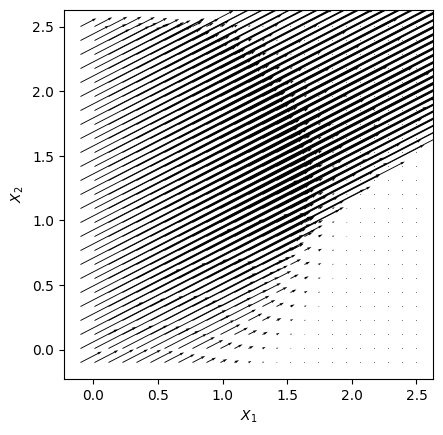

In [21]:
npts = 25
xmin, xmax = -0.1, 2.5
x1 = np.linspace(xmin, xmax, npts)
x2 = np.linspace(xmin, xmax, npts)

X1_25, X2_25 = np.meshgrid(x1, x2)

analytical_X = np.vstack([X1_25.flatten(), X2_25.flatten()]).T
vf_ctrl_0 = vector_field_function(analytical_X, adata.uns['VecFld_umap'], X_ctrl_ind=126)

import matplotlib.pyplot as plt 
plt.quiver(X1_25, X2_25, vf_ctrl_0[:, 0], vf_ctrl_0[:, 1], units='xy', 
           scale=1) # , color = norm, 
plt.gca().set_aspect('equal') #, adjustable='box'
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.savefig("./figures/fig4_control_point_164.pdf", dpi=300, transparent=False)


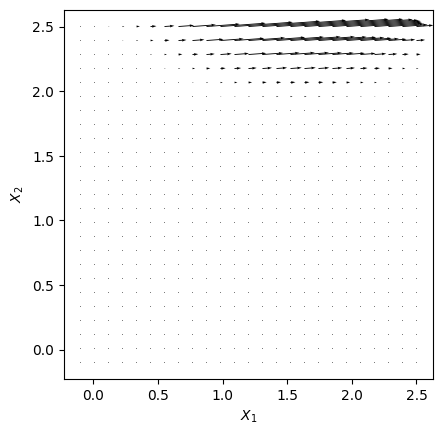

In [22]:
npts = 25
xmin, xmax = -0.1, 2.5
x1 = np.linspace(xmin, xmax, npts)
x2 = np.linspace(xmin, xmax, npts)

X1_25, X2_25 = np.meshgrid(x1, x2)

analytical_X = np.vstack([X1_25.flatten(), X2_25.flatten()]).T
vf_ctrl_0 = vector_field_function(analytical_X, adata.uns['VecFld_umap'], X_ctrl_ind=63)

import matplotlib.pyplot as plt 
plt.quiver(X1_25, X2_25, vf_ctrl_0[:, 0], vf_ctrl_0[:, 1], units='xy', 
           scale=2) # , color = norm, 
plt.gca().set_aspect('equal') #, adjustable='box'
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.savefig("./figures/fig4_control_point_234.pdf",  dpi=300, transparent=False)


### Create streamline plot for the two-gene system and simulate the noisy in our input data
1. set up the two-gene network motif system
2. plot quiver, streamline plot for this system 
3. corrupt the velocity data and visualize the resulatnt velocity quiver plots
4. estimate fixed points, nullcline, separatrix for this system 

Note that estimating seapratrix is generally challenging. 

[[0.004 1.996]
 [0.488 1.512]
 [1.    1.   ]
 [1.512 0.488]
 [1.996 0.004]]


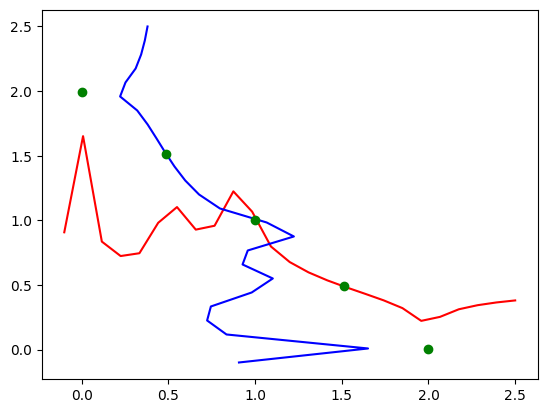

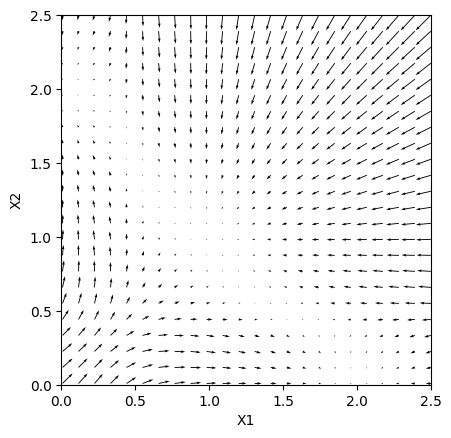

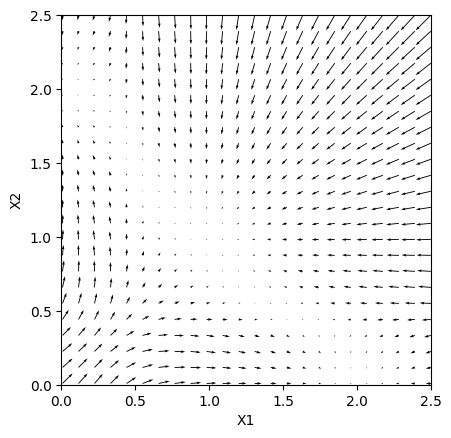

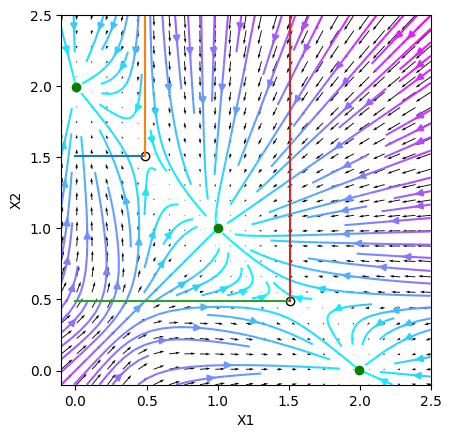

In [23]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.optimize import fsolve 


def huang_motif(X, a = 1, b = 1, k = 1, S = 0.5, n = 4):
    """two-gene mutual inhibition / self-activation model."""
    x1, x2 = X
    return np.array([a * x1**n / (S**n + x1**n) + b * S**n/(S**n + x2**n) - k * x1,
                     a * x2**n / (S**n + x2**n) + b * S**n/(S**n + x1**n) - k * x2])

# Use default parameters
a = 1
b = 1
k = 1
S = 0.5
n = 4
args = (a, b, k, S, n)

# Solve the steady state, nucline, separatrix 
# calculate nucline: 
npts = 25
xmin, xmax = -0.1, 2.5
x1 = np.linspace(xmin, xmax, npts)
x2 = np.linspace(xmin, xmax, npts)

plt.plot(x1, abs( 1/(k*x1 - a*x1**n / (S**n + x1**n) + 1e-10) * b*S**n - S**n)**(1/n), 'r')
plt.plot(abs( 1/(k*x2 - a*x2**n / (S**n + x2**n) + 1e-10) * b*S**n - S**n)**(1/n), x2, 'b')

sol = np.zeros((npts**2, 2))
for i in range(npts): 
    for j in range(npts):
        sol1 = fsolve(huang_motif, [x1[i], x2[j]])
        sol[i + j * npts, :] = sol1

uniq_sol = np.unique(np.round(sol, 3), axis = 0)
for i in uniq_sol:
    plt.plot(i[0], i[1], 'go')

print(uniq_sol)

X1, X2 = np.meshgrid(x1, x2)
dX1, dX2 = huang_motif([X1, X2])
norm = np.sqrt(dX1**2 + dX2**2)

# random sample 100 data points and make 10% as wrong 
X1.shape
X = np.vstack((X1.flatten(), X2.flatten())).T
V = np.vstack((dX1.flatten(), dX2.flatten())).T
# idx = np.random.random_integers(X.shape[0], 100)

f = plt.figure()
plt.quiver(X1, X2, dX1, dX2) # , color = norm, 
plt.xlim([0, xmax])
plt.ylim([0, xmax])
plt.gca().set_aspect('equal') #, adjustable='box'
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()
f.savefig("./figures/quiver_sparse_sampling.pdf")

f = plt.figure()
plt.quiver(X1, X2, dX1, dX2) # , color = norm, 
plt.xlim([0, xmax])
plt.ylim([0, xmax])
plt.gca().set_aspect('equal') #, adjustable='box'
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()
f.savefig("./figures/quiver.pdf")

f = plt.figure()
plt.quiver(X1, X2, dX1, dX2) # , color = norm, 
plt.streamplot(X1, X2, dX1, dX2, color = norm, cmap = plt.cm.cool, density = 1)
plt.gca().set_aspect('equal') #, adjustable='box'
for i in range(len(uniq_sol)):
    if i % 2 == 0: 
        plt.plot(uniq_sol[i][0], uniq_sol[i][1], 'go')
    else: 
        plt.plot(uniq_sol[i][0], uniq_sol[i][1], 'go', markerfacecolor='white', markeredgecolor='black')
        plt.plot([0, uniq_sol[i][0]], [uniq_sol[i][1], uniq_sol[i][1]], # x1, y1, x2, y2
                 [uniq_sol[i][0], uniq_sol[i][0]], [xmax, uniq_sol[i][1]] )

# add separatrix: 
plt.plot([0, ], [0, ], [2.5, ], [2.5, ], color = 'r')
plt.plot(0, 0, 2.5, 2.5, color = 'r')

plt.xlim([-0.1, xmax])
plt.ylim([-0.1, xmax])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()
f.savefig("./figures/streamline.pdf")
# # Initial condition
# ab0 = np.array([1, 1.1])

# # Solve
# t = np.linspace(0, 30, 200)
# ab = scipy.integrate.odeint(toggle, ab0, t, args=args)

# # Plot
# plt.plot(t, ab)
# plt.xlabel('t')
# plt.ylabel('a, b')
# plt.legend(('a', 'b'));

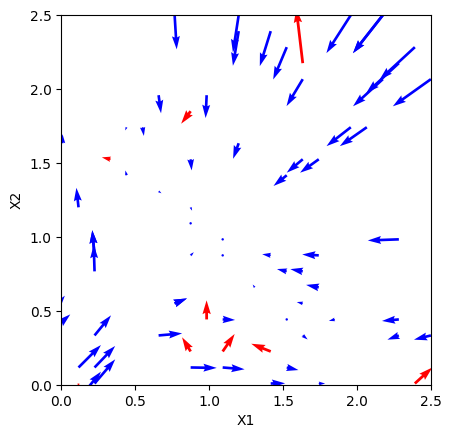

In [24]:
X = np.vstack((X1.flatten(), X2.flatten())).T
V = np.vstack((dX1.flatten(), dX2.flatten())).T
idx = np.random.random_integers(0, X.shape[0] - 1, 80)
err_idx = idx[0:10]
V[err_idx, ] = np.random.normal(size = (10, 2))

f = plt.figure()
plt.quiver(X[idx[10:], 0], X[idx[10:], 1], V[idx[10:], 0], V[idx[10:], 1], color = 'b') # , color = norm, 
plt.quiver(X[err_idx, 0], X[err_idx, 1], V[err_idx, 0], V[err_idx, 1], color = 'r') # , color = norm, 
plt.xlim([0, xmax])
plt.ylim([0, xmax])
plt.gca().set_aspect('equal') #, adjustable='box'
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()
f.savefig("./figures/quiver_sparse_sampling.pdf")


In [25]:
toggle_adata = dyn.sim.Simulator(motif='toggle')

In [26]:
toggle_adata.var['use_for_transition'] = True

Trying to set attribute `.var` of view, copying.


In [27]:
toggle_adata

AnnData object with n_obs × n_vars = 5000 × 2
    var: 'use_for_transition'
    layers: 'velocity'

In [28]:
toggle_adata.obsm['X_pca'] = toggle_adata.X.copy()
toggle_adata.obsm['velocity_pca'] = toggle_adata.layers['velocity']

In [29]:
dyn.vf.VectorField(toggle_adata, basis='pca', velocity_key='velocity')

AnnData object with n_obs × n_vars = 5000 × 2
    obs: 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca'
    var: 'use_for_transition'
    uns: 'VecFld_pca', 'VecFld'
    obsm: 'X_pca', 'velocity_pca', 'velocity_pca_SparseVFC', 'X_pca_SparseVFC'
    layers: 'velocity'

In [30]:
dyn.vf.VectorField(toggle_adata, basis='pca', velocity_key='velocity', M = 100, a = 5, beta = 0.1, ecr = 1e-5, gamma = 0.9, lambda_ = 3, minP = 1e-5, MaxIter = 500, theta = 0.75)

AnnData object with n_obs × n_vars = 5000 × 2
    obs: 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca'
    var: 'use_for_transition'
    uns: 'VecFld_pca', 'VecFld'
    obsm: 'X_pca', 'velocity_pca', 'velocity_pca_SparseVFC', 'X_pca_SparseVFC'
    layers: 'velocity'

In [31]:
toggle_adata.obs['ntr'] = 0

<Figure size 600x400 with 0 Axes>

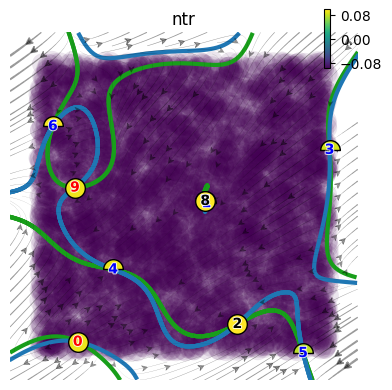

In [32]:
dyn.pl.topography(toggle_adata, basis='pca', terms=['streamline', 'nullcline', 'fixed_points',
             'separatrix'])

In [33]:
from dynamo.vectorfield.topography import VectorField2D
vecfld = VectorField2D(lambda x: vector_field_function(x, toggle_adata.uns['VecFld']['VecFld']))

In [34]:
toggle_adata.uns['VecFld'].keys()

dict_keys(['VecFld', 'VecFld2D', 'xlim', 'ylim'])

In [35]:
vecfld.find_fixed_points_by_sampling(10, [0, 6], [0, 6])


In [36]:
vecfld.compute_nullclines([0, 6], [0, 6], find_new_fixed_points=True)


In [37]:
from dynamo.vectorfield.topography import compute_separatrices


In [38]:
sep = compute_separatrices(vecfld.Xss.get_X(), vecfld.Xss.get_J(), vecfld.func, [0, 6], [0, 6])

[1.53728735 1.69222467]
[1]
u=-0.436293, 0.899805
[3.44624284 3.1118372 ]
[0 1]
u=-0.737642, -0.675192
u=0.534791, -0.844984
[3.44781121 3.1126481 ]
[0 1]
u=-0.741187, -0.671299
u=0.484654, -0.874706
[3.44552444 3.11107405]
[0 1]
u=-0.737576, -0.675264
u=0.535206, -0.844722
[4.10914162 0.56188549]
[]
[0.74464706 3.38716836]
[]
[0.28748876 4.65866541]
[1]
u=0.384295, 0.923210


In [39]:
def plot_fixed_points(vecfld, ax=None, markersize=20, markercolor='k', filltype=['full', 'top', 'none']):
    """Plot fixed points stored in the VectorField2D class."""
    Xss, ftype = vecfld.get_fixed_points(get_types=True)
    if ax is None:
        ax = plt.gca()
    for i in range(len(Xss)):
        ax.plot(*Xss[i], marker='o', markersize=markersize, c=markercolor, fillstyle=filltype[int(ftype[i] + 1)], linestyle='none')
        
def plot_nullclines(vecfld, ax=None, colors=['#189e1a', '#1f77b4'], lw=3):
    """Plot nullclines stored in the VectorField2D class.
    """
    if ax is None:
        ax = plt.gca()
    for ncx in vecfld.NCx:
        plt.plot(*ncx.T, c=colors[0], lw=lw)
    for ncy in vecfld.NCy:
        plt.plot(*ncy.T, c=colors[1], lw=lw)

In [40]:
from dynamo.plot.topography import plot_flow_field

In [41]:
import matplotlib.pyplot as plt

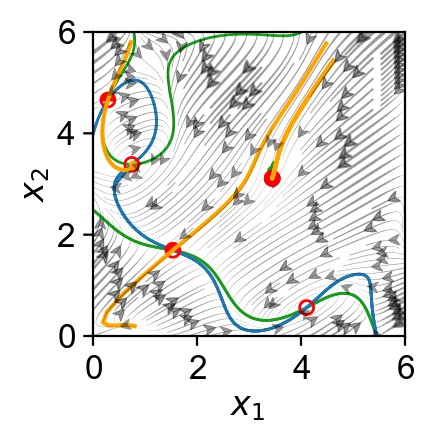

In [42]:
dyn.configuration.set_pub_style(scaler=2)
fig = plt.figure(figsize=(2, 2))
plot_flow_field(vecfld, [0, 6], [0, 6], n_grid=100, color='grey')
plot_nullclines(vecfld, lw=1)
plot_fixed_points(vecfld, markersize=5, markercolor='r')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
for s in sep:
    plt.plot(*s.T, 'orange')

In [43]:
fig.savefig('./figures/topology_compare.pdf', bbox_inches = "tight", transparent=True)

<Figure size 600x400 with 0 Axes>

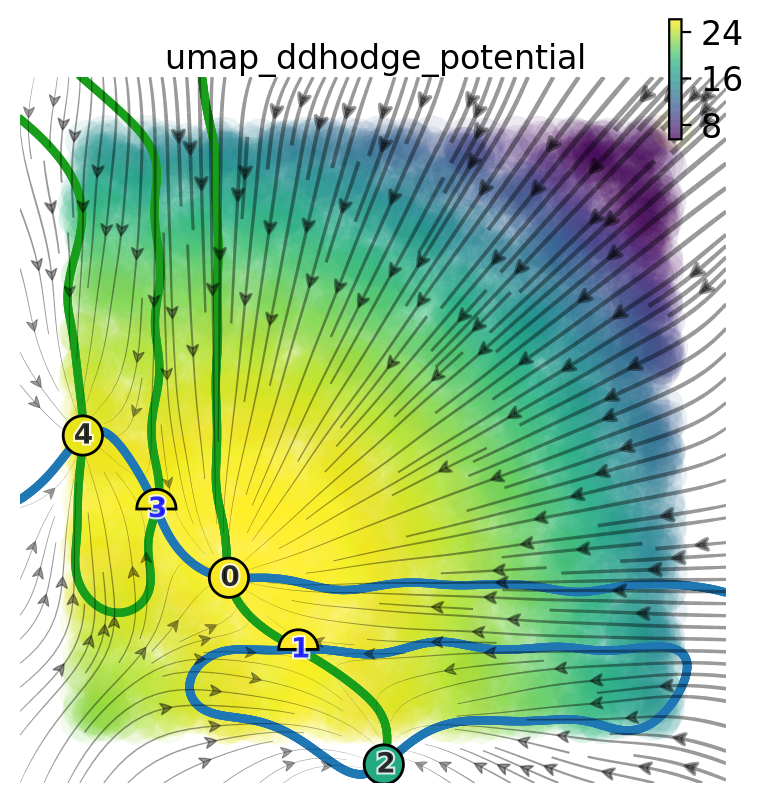

In [44]:
adata.obsm["X_umap"] = adata.X.copy()
adata.obsm["X_pca"] = adata.X.copy()
# dyn.vf.VectorField(adata, basis='umap', pot_curl_div=True)
# plot potential and topography
dyn.pl.topography(adata, color='umap_ddhodge_potential', terms=['streamline', 'nullcline', 'fixed_points',
             'separatrix'])

### Benchmark the vector field reconstruction
1. Calculate the true Jacobian, acceleration, curvature, divergence and curl, etc. for the true vector field function 
2. Draw the pairwise scatterplots between the recovered and true Jacobian
3. Draw the residual heatmap (true Jacobian - recovered Jacobian)
4. Draw the pairwise scatterplots and residual heatmap for acceleration, curvature, curl and divergence. 


#### Calculate the true Jacobian, acceleration, curvature, divergence and curl, etc. for the true vector field function 

In [45]:
#(x, t=None, a1=1, a2=1, b1=1, b2=1, k1=1, k2=1, S=0.5, n=4)

vf = two_genes_motif

def f_jac(X):
    if X.ndim == 1: X = X.reshape((1, -1))
    J = np.zeros((X.shape[1], X.shape[1], X.shape[0]))
    for ind, i in enumerate(X):
        J[:, :, ind] = two_genes_motif_jacobian(i[0], i[1])
    return J

# set up the dictionary for the true acceleration, curvature, curl and divergence

X = adata.X
analytical_acc = compute_acceleration(vf, f_jac, X, return_all=False)
analytical_cur = compute_curvature(vf, f_jac, X, formula=2)
analytical_curl = compute_curl(f_jac, X)
analytical_div = compute_divergence(f_jac, X, vectorize_size=1)

adata.obs['analytical_curvature'], adata.obsm['curvature_pca_true'] = analytical_cur
adata.obs['analytical_acceleration'], adata.obsm['acceleration_pca_true'] = analytical_acc
adata.obsm['X_pca_true'] = adata.obsm['X_pca'].copy()

adata.obs['analytical_curl'] = analytical_curl.copy()
adata.obs['analytical_div'] = analytical_div.copy()


# set up the dictionary for the true jacobian
J_dict = adata.uns['jacobian_umap'].copy()

J = np.zeros_like(J_dict['jacobian'])
for ind, i in enumerate(adata.X):
    J[:, :, ind] = dyn.sim.two_genes_motif_jacobian(i[0], i[1])

J_dict['jacobian'] = J
adata.uns['jacobian_true'] = J_dict
adata.obsm['X_true'] = adata.obsm['X_umap']

Calculating divergence: 100%|██████████| 5000/5000 [00:00<00:00, 21417.50it/s]


In [46]:
dyn.configuration.set_pub_style()
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete


### pairwise scatterplot 

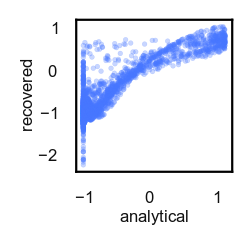

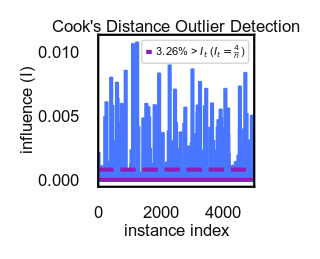

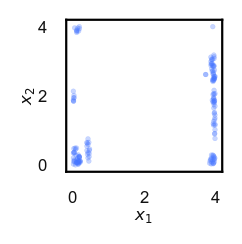

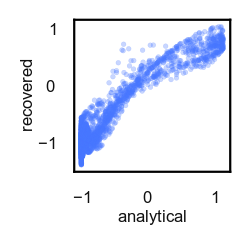

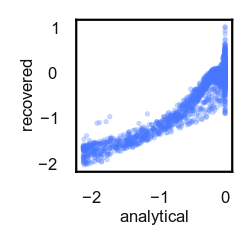

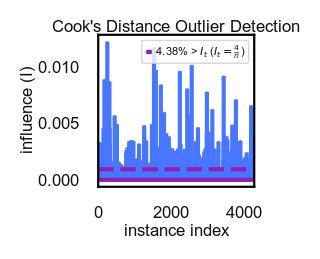

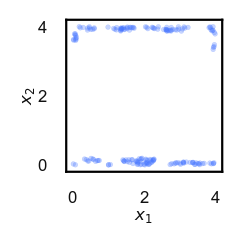

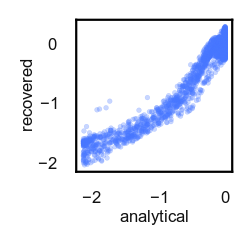

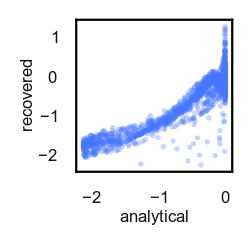

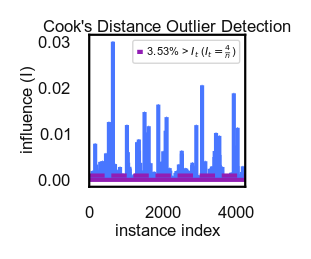

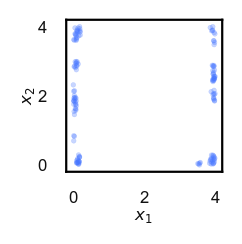

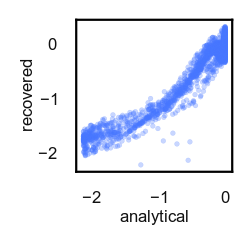

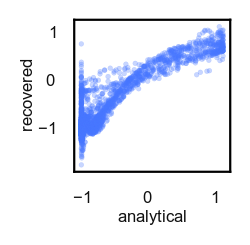

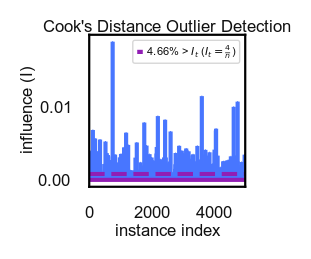

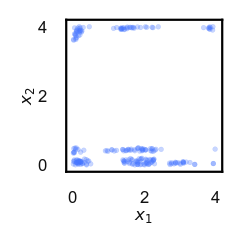

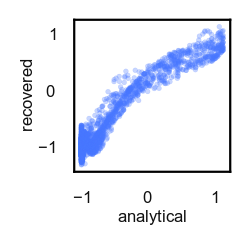

In [48]:
dyn.configuration.set_pub_style(scaler=1)
for x_ind in np.arange(2): 
    for y_ind in np.arange(2): 
        x, y = adata.uns['jacobian_true']['jacobian'][x_ind, y_ind], adata.uns['jacobian_umap']['jacobian'][x_ind, y_ind]

        plt.figure(figsize=(1, 1))
        sns.scatterplot(x, y, edgecolor=None, alpha=0.3, s=3)
        plt.xlabel('analytical')
        plt.ylabel('recovered')
        plt.savefig(fname='./figures/jacobian_' + str(x_ind) + str(y_ind) + '_compare.pdf', dpi=300, bbox_inches = "tight", transparent=True)


        plt.figure(figsize=(1, 1))

        # Instantiate and fit the visualizer
        visualizer = CooksDistance()
        if (x_ind == 0 and y_ind == 1) or (x_ind == 1 and y_ind == 0):
            valid_inds = np.where(x > -0.5)[0]
            visualizer.fit(-1 - x[valid_inds].reshape(-1, 1), y[valid_inds])
        else:
            visualizer.fit(x.reshape(-1, 1), y)

        visualizer.show()

        plt.savefig(fname='./figures/jacobian_' + str(x_ind) + str(y_ind) + '_cook.pdf', dpi=300, bbox_inches = "tight", transparent=True)

        plt.figure(figsize=(1, 1))
        if (x_ind == 0 and y_ind == 1) or (x_ind == 1 and y_ind == 0):
            subset_X = adata.X[valid_inds, :]
            sns.scatterplot(subset_X[visualizer.distance_ > visualizer.influence_threshold_, 0], 
                                    subset_X[visualizer.distance_ > visualizer.influence_threshold_, 1], edgecolor=None, alpha=0.3, s=3)
        else:
            sns.scatterplot(adata.X[visualizer.distance_ > visualizer.influence_threshold_, 0], 
                        adata.X[visualizer.distance_ > visualizer.influence_threshold_, 1], edgecolor=None, alpha=0.3, s=3)
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.savefig(fname='./figures/outlier_' + str(x_ind) + str(y_ind) + 'coord.pdf', dpi=300, bbox_inches = "tight", transparent=True)

        plt.figure(figsize=(1, 1))
        if (x_ind == 0 and y_ind == 1) or (x_ind == 1 and y_ind == 0):
            x[valid_inds[visualizer.distance_ > visualizer.influence_threshold_]] = np.nan 
            y[valid_inds[visualizer.distance_ > visualizer.influence_threshold_]] = np.nan 
            sns.scatterplot(x, y, edgecolor=None, alpha=0.3, s=3)
        else:
            sns.scatterplot(x[visualizer.distance_ < visualizer.influence_threshold_], 
                            y[visualizer.distance_ < visualizer.influence_threshold_], alpha=0.3, edgecolor=None, s=3)

        plt.xlabel('analytical')
        plt.ylabel('recovered')
        plt.savefig(fname='./figures/jacobian_' + str(x_ind) + str(y_ind) + '_compare_outlier_removed.pdf', dpi=300, bbox_inches = "tight", transparent=True)

    

In [49]:
genes = adata.uns['jacobian_umap']['regulators']

x_ind, y_ind = 0, 1
print(adata.uns['jacobian_umap']['jacobian'][x_ind, y_ind][:5])
print(adata.uns['jacobian_true']['jacobian'][x_ind, y_ind][:5])

differences = adata.uns['jacobian_true']['jacobian'][x_ind, y_ind] - adata.uns['jacobian_umap']['jacobian'][x_ind, y_ind]
print(differences)
adata.uns['jacobian_umap']['jacobian'][x_ind, y_ind] = differences 

print(adata.uns['jacobian_umap']['jacobian'][x_ind, y_ind][:5])

[-0.39620515 -0.0042718  -0.09334297 -0.12507695 -0.14897124]
[-0.30630618 -0.10489179 -0.00132051 -0.00053091 -0.00107695]
[ 0.08989897 -0.10062     0.09202245 ... -0.07933525         nan
 -0.06742502]
[ 0.08989897 -0.10062     0.09202245  0.12454604  0.14789429]


### plot the residual 

[-0.23182554  0.23239244  0.03689012 ...  0.05562677  0.32141278
 -0.08289171]
Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_jacobian_residualPu.1->Pu.1_dyn_savefig.pdf...
Done
[-0.39620515 -0.0042718  -0.09334297 ...  0.06589231         nan
  0.06719285]
Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_jacobian_residualPu.1->Gata.1_dyn_savefig.pdf...
Done
[-0.21561639 -0.15842839  0.02138816 ...  0.0356794  -0.13704435
  0.15132623]
Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_jacobian_residualGata.1->Pu.1_dyn_savefig.pdf...
Done
[-0.14825893  0.12433987 -0.03487795 ...  0.05445736 -0.14267191
  0.082272  ]
Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_jacobian_residualGata.1->Gata.1_dyn_savefig.pdf...
Done


<Figure size 600x400 with 0 Axes>

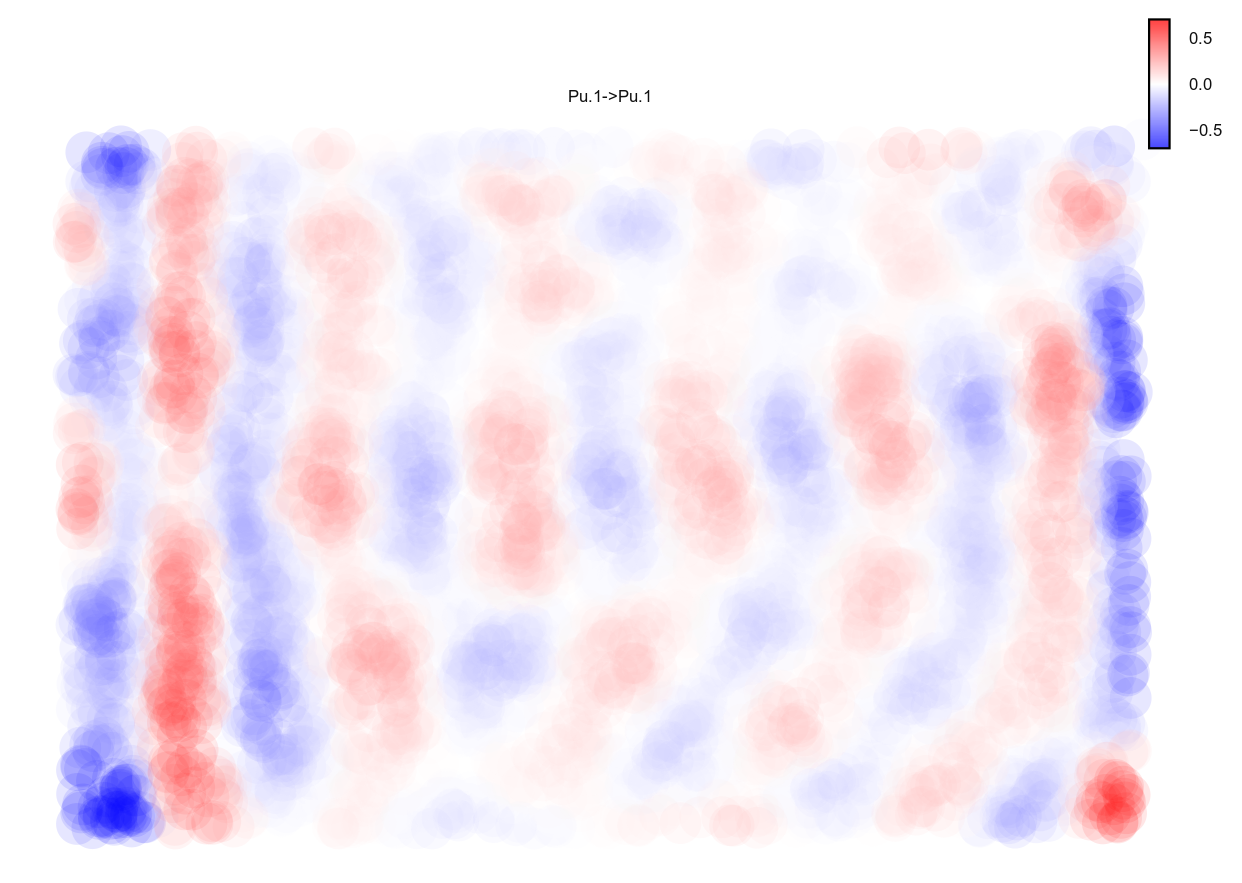

<Figure size 200x200 with 0 Axes>

<Figure size 600x400 with 0 Axes>

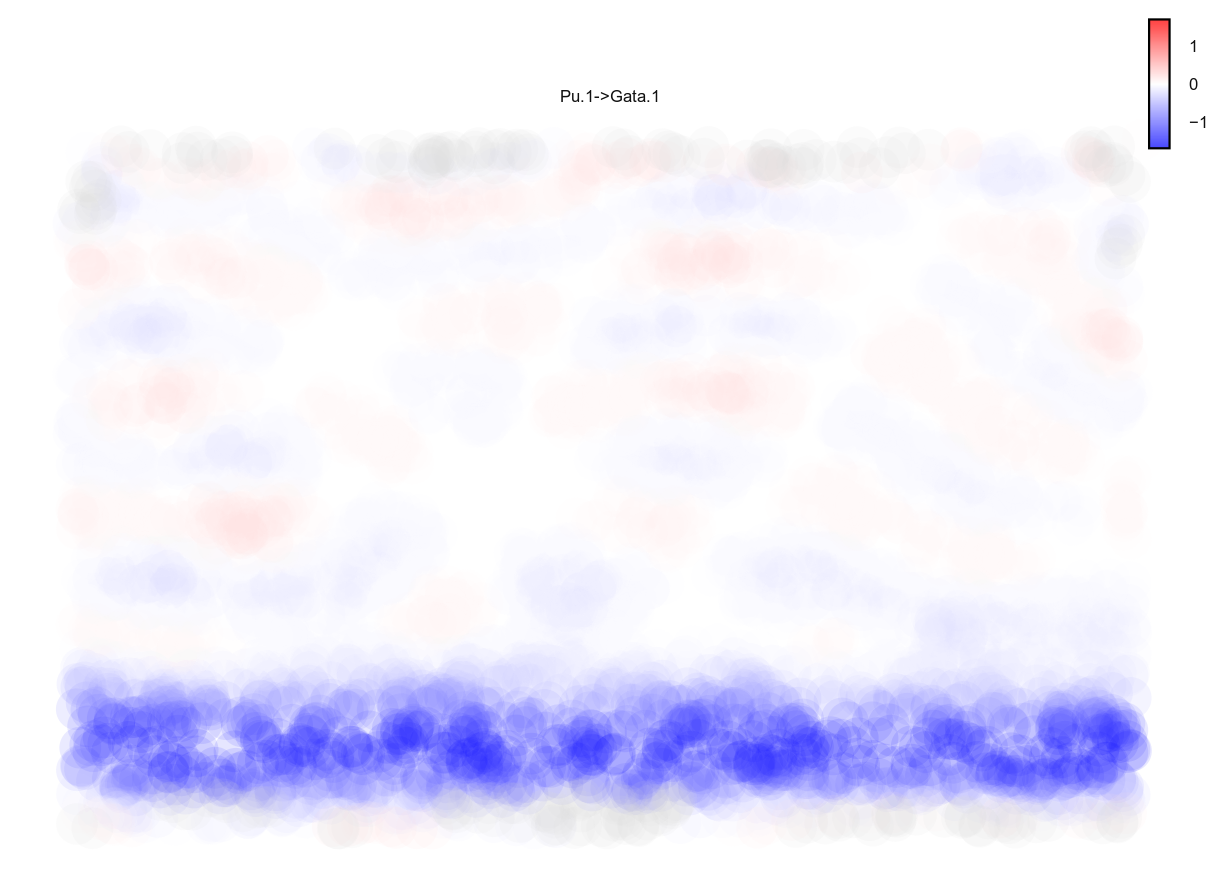

<Figure size 200x200 with 0 Axes>

<Figure size 600x400 with 0 Axes>

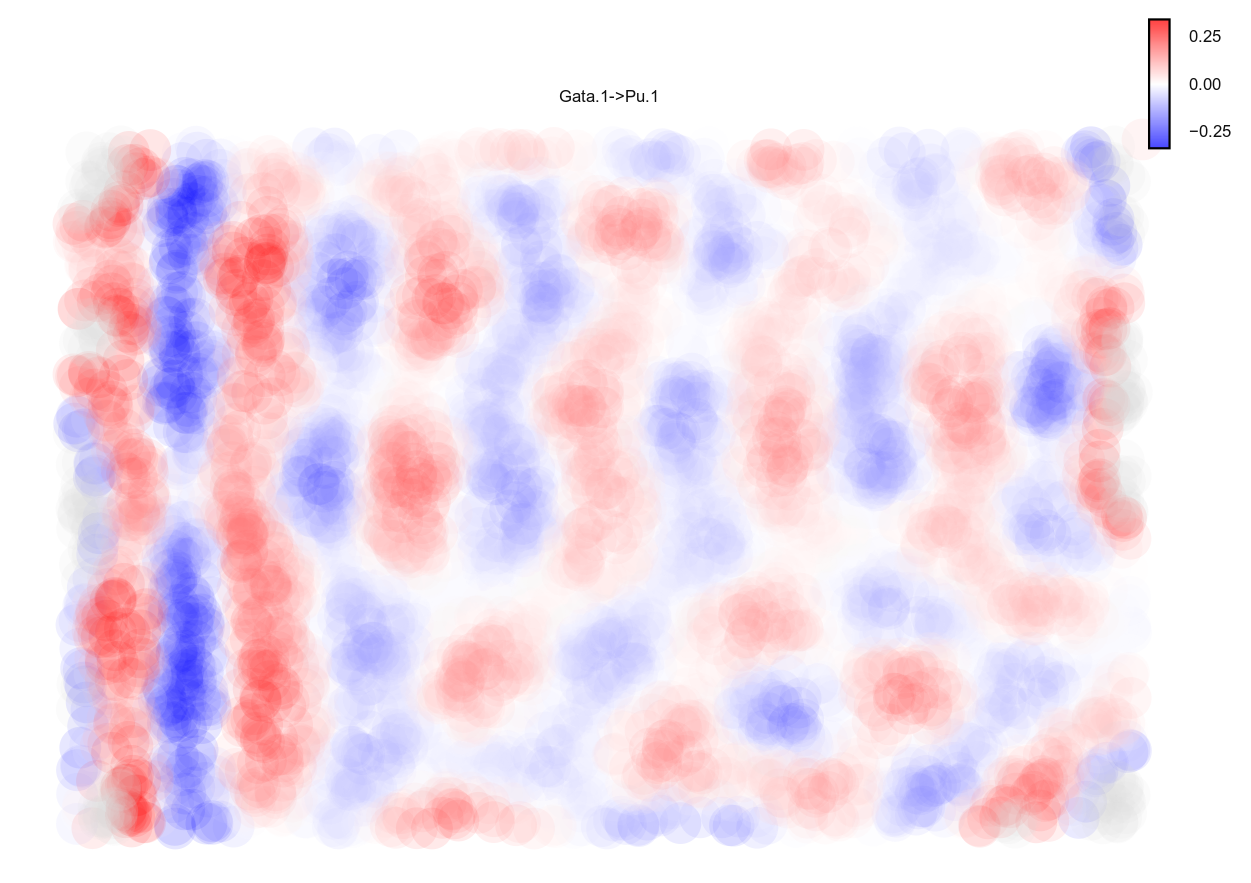

<Figure size 200x200 with 0 Axes>

<Figure size 600x400 with 0 Axes>

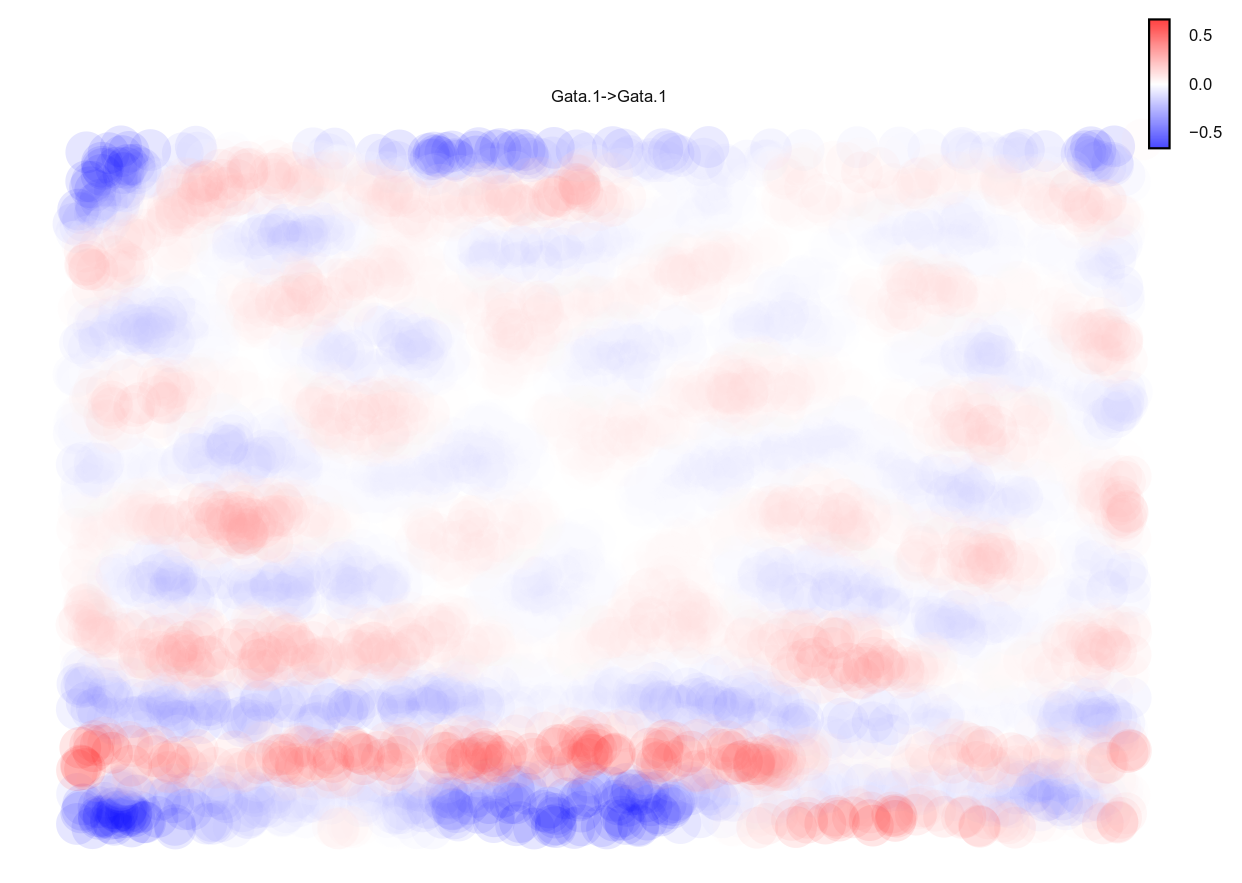

<Figure size 200x200 with 0 Axes>

In [50]:
x, y = adata.uns['jacobian_true']['jacobian'][x_ind, y_ind], adata.uns['jacobian_umap']['jacobian'][x_ind, y_ind]

dyn.configuration.set_pub_style(scaler=1)
genes = adata.uns['jacobian_umap']['regulators']
for x_ind in np.arange(2): 
    for y_ind in np.arange(2): 
        differences = adata.uns['jacobian_true']['jacobian'][x_ind, y_ind] - adata.uns['jacobian_umap']['jacobian'][x_ind, y_ind]
        print(differences)
        key = genes[x_ind] + '->' + genes[y_ind]
        adata.obs[key] = differences
        
        dyn.pl.scatters(adata, color= key, cmap='bwr', sym_c=True)
        dyn.pl.scatters(adata, color= key, cmap='bwr', sym_c=True, 
                        pointsize = 0.01, save_show_or_return='save', alpha=1,
                       save_kwargs={'prefix': './figures/Fig4_jacobian_residual' + key, 'ext': 'pdf',
                                     "bbox_inches": None},
                        figsize=(2, 2))

#         for x_ind in np.arange(2): 
#     for y_ind in np.arange(2): 
#         x, y = adata.uns['jacobian_true']['jacobian'][x_ind, y_ind], adata.uns['jacobian_umap']['jacobian'][x_ind, y_ind]

### acceleration, curvature, curl and divergence 

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_residualacceleration_norm_dyn_savefig.pdf...
Done


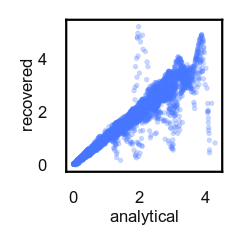

<Figure size 200x200 with 0 Axes>

In [51]:
plt.figure(figsize=(1, 1))
sns.scatterplot(adata.obs['analytical_acceleration'], 
                adata.obs['acceleration_pca'], edgecolor=None, alpha=0.3, s=3)
plt.xlabel('analytical')
plt.ylabel('recovered')
plt.savefig(fname='./figures/acceleration_norm_compare.pdf', dpi=300, bbox_inches = "tight", transparent=True)

key = 'acceleration_norm'
adata.obs[key] = adata.obs['analytical_acceleration'] - adata.obs['acceleration_pca']
dyn.pl.scatters(adata, color= key, cmap='bwr', sym_c=True, 
                pointsize = 0.01, save_show_or_return='save', alpha=1,
               save_kwargs={'prefix': './figures/Fig4_residual' + key, 'ext': 'pdf',
                             "bbox_inches": None},
                figsize=(2, 2))

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_residualcurvature_norm_dyn_savefig.pdf...
Done


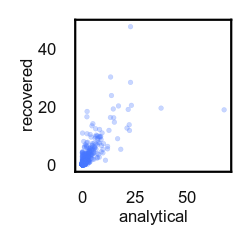

<Figure size 200x200 with 0 Axes>

In [52]:
plt.figure(figsize=(1, 1))
sns.scatterplot(adata.obs['analytical_curvature'], 
                adata.obs['curvature_pca'], edgecolor=None, alpha=0.3, s=3)
plt.xlabel('analytical')
plt.ylabel('recovered')
plt.savefig(fname='./figures/curvature_norm_compare.pdf', dpi=300, bbox_inches = "tight", transparent=True)

key = 'curvature_norm'
adata.obs[key] = adata.obs['analytical_curvature'] - adata.obs['curvature_pca']
dyn.pl.scatters(adata, color= key, cmap='bwr', sym_c=True, alpha=1,
                pointsize = 0.01, save_show_or_return='save', 
               save_kwargs={'prefix': './figures/Fig4_residual' + key, 'ext': 'pdf',
                             "bbox_inches": None},
                figsize=(2, 2))

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_residualcurl_compare_dyn_savefig.pdf...
Done


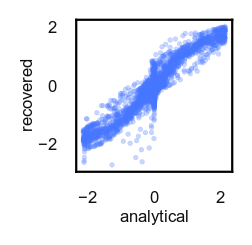

<Figure size 200x200 with 0 Axes>

In [53]:
plt.figure(figsize=(1, 1))
sns.scatterplot(adata.obs['analytical_curl'], 
                adata.obs['curl_pca'], edgecolor=None, alpha=0.3, s=3)
plt.xlabel('analytical')
plt.ylabel('recovered')
plt.savefig(fname='./figures/curl_compare.pdf', dpi=300, bbox_inches = "tight", transparent=True)

key = 'curl_compare'
adata.obs[key] = adata.obs['analytical_curl'] - adata.obs['curl_pca']
dyn.pl.scatters(adata, color= key, cmap='bwr', sym_c=True, alpha=1,
                pointsize = 0.01, save_show_or_return='save', 
               save_kwargs={'prefix': './figures/Fig4_residual' + key, 'ext': 'pdf',
                             "bbox_inches": None},
                figsize=(2, 2))

Saving figure to /lab/solexa_weissman/xqiu/proj/Aristotle/data/Fig4/./figures/Fig4_residualdivergence_compare_dyn_savefig.pdf...
Done


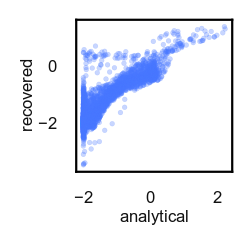

<Figure size 200x200 with 0 Axes>

In [54]:
plt.figure(figsize=(1, 1))
sns.scatterplot(adata.obs['analytical_div'], 
                adata.obs['divergence_pca'], edgecolor=None, alpha=0.3, s=3)
plt.xlabel('analytical')
plt.ylabel('recovered')
plt.savefig(fname='./figures/divergence_compare.pdf', dpi=300, bbox_inches = "tight", transparent=True)

key = 'divergence_compare'
adata.obs[key] = adata.obs['analytical_div'] - adata.obs['divergence_pca']
dyn.pl.scatters(adata, color= key, cmap='bwr', sym_c=True, alpha=1,
                pointsize = 0.01, save_show_or_return='save', 
               save_kwargs={'prefix': './figures/Fig4_residual' + key, 'ext': 'pdf',
                             "bbox_inches": None},
                figsize=(2, 2))

In [55]:
# plot the residual instead 

### Benchmark the computational efficency of vector field reconstruction
1. Compare the numerical and analytical Jacobian, acceleration, curvature, divergence and curl, etc. estiamtion for the true vector field function 
2. The zebrafish dataset is also used for the purpose of benchmarking the differential geometry quantity calculation in high dimensional space.  

Note that the numerical differential geometry quantities is also only possible with a vector field function 

In [56]:
import time
tic = time.perf_counter()
dyn.vf.jacobian(adata, method='analytical')
toc = time.perf_counter()
sim_jacobian_analytical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Downloaded the tutorial in 0.4456 seconds


In [57]:
import time
tic = time.perf_counter()
dyn.vf.jacobian(adata, method='numerical')
toc = time.perf_counter()
sim_jacobian_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")

Downloaded the tutorial in 7.8205 seconds


In [58]:
import time
tic = time.perf_counter()
dyn.vf.acceleration(adata, method='analytical')
toc = time.perf_counter()
sim_acceleration_analytical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating acceleration: 100%|██████████| 5000/5000 [00:00<00:00, 131480.41it/s]

Downloaded the tutorial in 0.4158 seconds


In [59]:
import time
tic = time.perf_counter()
dyn.vf.acceleration(adata, method='numerical')
toc = time.perf_counter()
sim_acceleration_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating acceleration: 100%|██████████| 5000/5000 [00:00<00:00, 125752.66it/s]

Downloaded the tutorial in 7.5109 seconds


In [60]:
import time
tic = time.perf_counter()
dyn.vf.curvature(adata, method='analytical')
toc = time.perf_counter()
sim_curvature_analytical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating curvature: 100%|██████████| 5000/5000 [00:00<00:00, 42206.32it/s]

Downloaded the tutorial in 0.5887 seconds


In [61]:
import time
tic = time.perf_counter()
dyn.vf.curvature(adata, method='numerical')
toc = time.perf_counter()
sim_curvature_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating curvature: 100%|██████████| 5000/5000 [00:00<00:00, 55983.02it/s]

Downloaded the tutorial in 7.4911 seconds


In [62]:
import time
tic = time.perf_counter()
dyn.vf.curl(adata, method='analytical')
toc = time.perf_counter()
sim_curl_analytical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating 2-D curl: 100%|██████████| 5000/5000 [00:00<00:00, 9039.86it/s]

Downloaded the tutorial in 0.5566 seconds


In [63]:
import time
tic = time.perf_counter()
dyn.vf.curl(adata, method='numerical')
toc = time.perf_counter()
sim_curl_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating 2-D curl: 100%|██████████| 5000/5000 [00:25<00:00, 195.71it/s]

Downloaded the tutorial in 25.5516 seconds


In [64]:
import time
tic = time.perf_counter()
dyn.vf.divergence(adata, method='analytical')
toc = time.perf_counter()
sim_divergence_analytical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating divergence with precomputed Jacobians: 5000it [00:00, 68974.60it/s]
Calculating divergence: 0it [00:00, ?it/s]

Downloaded the tutorial in 0.0783 seconds


In [65]:
import time
tic = time.perf_counter()
dyn.vf.divergence(adata, method='numerical')
toc = time.perf_counter()
sim_divergence_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating divergence with precomputed Jacobians: 5000it [00:00, 74235.21it/s]
Calculating divergence: 0it [00:00, ?it/s]

Downloaded the tutorial in 0.0723 seconds


### zebrafish data 

In [66]:
zebrafish = dyn.read('../zebrafish/zebrafish_adata_processed.h5ad')


In [67]:
adata.uns['VecFld_umap']['X']
adata.uns['VecFld_umap']['Y']
adata.uns['VecFld_pca']['X']
adata.uns['VecFld_pca']['Y']

array([[ 0.03776783,  0.99296478],
       [-0.12975839, -0.16853164],
       [-1.50288353, -1.85217927],
       ...,
       [-2.11604794, -0.79531823],
       [-2.2314847 , -2.97959059],
       [ 0.0149383 , -0.76678471]])

In [68]:
from dynamo.vectorfield.utils import vecfld_from_adata
vecfld_from_adata(adata, 'pca')[0]['X']

array([[0.03942794, 0.92983943],
       [1.123868  , 1.174422  ],
       [2.5022345 , 2.8528283 ],
       ...,
       [3.121442  , 1.789924  ],
       [3.2311606 , 3.9799147 ],
       [0.90527064, 1.8465757 ]], dtype=float32)

In [69]:
dyn.vf.VectorField(zebrafish, basis='umap', pot_curl_div=False, M=1000, MaxIter=100) # , M=1000, MaxIter=1000

dyn.vf.VectorField(zebrafish, basis='pca', pot_curl_div=False, M=1000, MaxIter=100) # , M=1000, MaxIter=1000

AnnData object with n_obs × n_vars = 4181 × 2000
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'speed_pca', 'divergence_pca', 'acceleration_pca', 'curvature_pca'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'PCs', 'VecFld', 'VecFld_pca', 'VecFld_umap', 'dynamics

In [70]:
tic = time.perf_counter()
dyn.vf.jacobian(zebrafish, sampling=None,  store_in_adata=True)
# dyn.vf.jacobian(zebrafish, sampling=None)
toc = time.perf_counter()
zeb_jacobian_analytical_t = toc - tic

print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")

Downloaded the tutorial in 2.4059 seconds


In [71]:
import time
tic = time.perf_counter()
dyn.vf.jacobian(zebrafish, sampling=None, method='numerical', store_in_adata=True)
toc = time.perf_counter()
zeb_jacobian_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Downloaded the tutorial in 847.7198 seconds


In [72]:

tic = time.perf_counter()
dyn.vf.acceleration(zebrafish)
toc = time.perf_counter()
zeb_acceleration_analytical_t = toc - tic

print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")

Calculating acceleration: 100%|██████████| 4181/4181 [00:00<00:00, 137091.90it/s]

Downloaded the tutorial in 0.5823 seconds


In [73]:
import time
tic = time.perf_counter()
dyn.vf.acceleration(zebrafish, method='numerical')
toc = time.perf_counter()
zeb_acceleration_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating acceleration: 100%|██████████| 4181/4181 [00:00<00:00, 136468.86it/s]

Downloaded the tutorial in 11.5474 seconds


In [74]:

tic = time.perf_counter()
dyn.vf.curvature(zebrafish)
toc = time.perf_counter()
zeb_curvature_analytical_t = toc - tic

print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")

Calculating curvature: 100%|██████████| 4181/4181 [00:00<00:00, 61231.46it/s]


Downloaded the tutorial in 2.7558 seconds


In [75]:
import time
tic = time.perf_counter()
dyn.vf.curvature(zebrafish, method='numerical')
toc = time.perf_counter()
zeb_curvature_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating curvature: 100%|██████████| 4181/4181 [00:00<00:00, 65024.71it/s]


Downloaded the tutorial in 844.1109 seconds


In [76]:

tic = time.perf_counter()
dyn.vf.curl(zebrafish)
toc = time.perf_counter()
zeb_curl_analytical_t = toc - tic

print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")

Calculating 2-D curl: 100%|██████████| 4181/4181 [00:00<00:00, 10641.54it/s]

Downloaded the tutorial in 0.3958 seconds


In [77]:
import time
tic = time.perf_counter()
dyn.vf.curl(zebrafish, method='numerical')
toc = time.perf_counter()
zeb_curl_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating 2-D curl: 100%|██████████| 4181/4181 [00:24<00:00, 170.94it/s]

Downloaded the tutorial in 24.4621 seconds


In [78]:

tic = time.perf_counter()
dyn.vf.divergence(zebrafish)
toc = time.perf_counter()
zeb_divergence_analytical_t = toc - tic

print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")

Calculating divergence with precomputed Jacobians: 4181it [00:00, 64485.04it/s]
Calculating divergence: 0it [00:00, ?it/s]

Downloaded the tutorial in 0.0703 seconds


In [79]:
import time
tic = time.perf_counter()
dyn.vf.divergence(zebrafish, method='numerical')
toc = time.perf_counter()
zeb_divergence_numerical_t = toc - tic
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")


Calculating divergence with precomputed Jacobians: 4181it [00:00, 76899.47it/s]
Calculating divergence: 0it [00:00, ?it/s]

Downloaded the tutorial in 0.0595 seconds


In [80]:
zebrafish

AnnData object with n_obs × n_vars = 4181 × 2000
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'speed_pca', 'divergence_pca', 'acceleration_pca', 'curvature_pca', 'jacobian_det_pca', 'acceleration_umap'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'PCs', 'VecFld

#### plot those results 

In [81]:
import pandas as pd 

In [82]:
df = pd.DataFrame({"Jacobian": [sim_jacobian_analytical_t, sim_jacobian_numerical_t, zeb_jacobian_analytical_t, zeb_jacobian_numerical_t],
                   "Acceleration": [sim_acceleration_analytical_t, sim_acceleration_numerical_t, zeb_acceleration_analytical_t, zeb_acceleration_numerical_t],
                   "Curvature": [sim_curvature_analytical_t, sim_curvature_numerical_t, zeb_curvature_analytical_t, zeb_curvature_numerical_t],
                   "Curl": [sim_curl_analytical_t, sim_curl_numerical_t, zeb_curl_analytical_t, zeb_curl_numerical_t],
                   "Divergence": [sim_divergence_analytical_t, sim_divergence_numerical_t, zeb_divergence_analytical_t, zeb_divergence_numerical_t],
                   "type": ['analytical (5000 cells, 2 dimension)', 'numerical (5000 cells, 2 dimension)', 
                            'analytical (4181 cells, 30 dimension)', 'numerical (4181 cells, 30 dimension)'], 
                   "data": ['simulation', 'simulation', 'zebrafish', 'zebrafish']
                  })
df

Jacobian  Acceleration   Curvature       Curl  Divergence  \
0    0.445611      0.415832    0.588696   0.556571    0.078331   
1    7.820490      7.510899    7.491051  25.551601    0.072347   
2    2.405870      0.582340    2.755794   0.395765    0.070266   
3  847.719821     11.547351  844.110858  24.462091    0.059547   

                                    type        data  
0   analytical (5000 cells, 2 dimension)  simulation  
1    numerical (5000 cells, 2 dimension)  simulation  
2  analytical (4181 cells, 30 dimension)   zebrafish  
3   numerical (4181 cells, 30 dimension)   zebrafish

In [83]:
mlt_df = df.melt(id_vars=['type', 'data'])
mlt_df

type        data      variable  \
0    analytical (5000 cells, 2 dimension)  simulation      Jacobian   
1     numerical (5000 cells, 2 dimension)  simulation      Jacobian   
2   analytical (4181 cells, 30 dimension)   zebrafish      Jacobian   
3    numerical (4181 cells, 30 dimension)   zebrafish      Jacobian   
4    analytical (5000 cells, 2 dimension)  simulation  Acceleration   
5     numerical (5000 cells, 2 dimension)  simulation  Acceleration   
6   analytical (4181 cells, 30 dimension)   zebrafish  Acceleration   
7    numerical (4181 cells, 30 dimension)   zebrafish  Acceleration   
8    analytical (5000 cells, 2 dimension)  simulation     Curvature   
9     numerical (5000 cells, 2 dimension)  simulation     Curvature   
10  analytical (4181 cells, 30 dimension)   zebrafish     Curvature   
11   numerical (4181 cells, 30 dimension)   zebrafish     Curvature   
12   analytical (5000 cells, 2 dimension)  simulation          Curl   
13    numerical (5000 cells, 2 dimension)  simulation          Curl   
14  analytical (4181 cells, 30 dimension)   zebrafish          Curl   
15   numerical (4181 cells, 30 dimension)   zebrafish          Curl   
16   analytical (5000 cells, 2 dimension)  simulation    Divergence   
17    numerical (5000 cells, 2 dimension)  simulation    Divergence   
18  analytical (4181 cells, 30 dimension)   zebrafish    Divergence   
19   numerical (4181 cells, 30 dimension)   zebrafish    Divergence   

         value  
0     0.445611  
1     7.820490  
2     2.405870  
3   847.719821  
4     0.415832  
5     7.510899  
6     0.582340  
7    11.547351  
8     0.588696  
9     7.491051  
10    2.755794  
11  844.110858  
12    0.556571  
13   25.551601  
14    0.395765  
15   24.462091  
16    0.078331  
17    0.072347  
18    0.070266  
19    0.059547

<Figure size 500x100 with 0 Axes>

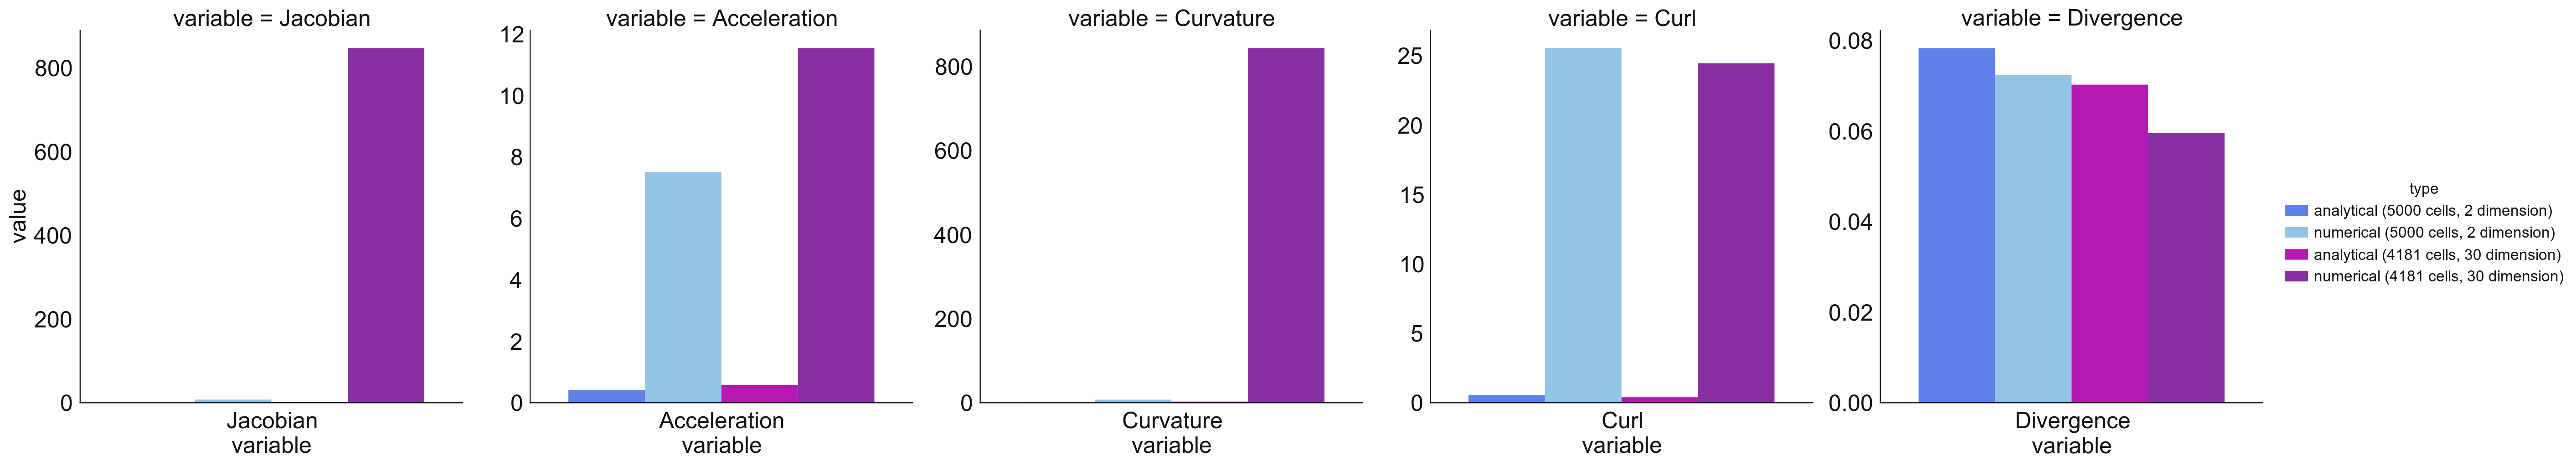

In [84]:
dyn.configuration.set_pub_style(scaler=3)
ax = plt.figure(figsize=(5, 1))
sns.catplot("variable", "value", data=mlt_df, hue='type', col="variable", 
            sharey=False, sharex=False, kind='bar', ax=ax)
plt.savefig(dpi=300, fname='./figures/running_time.pdf', bbox_inches = "tight", transparent=True)